scanpy==1.4.6.dev9+ge632939 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


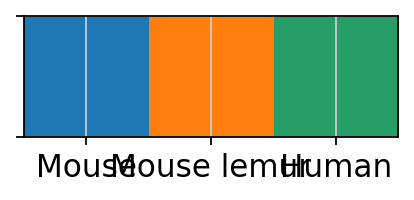

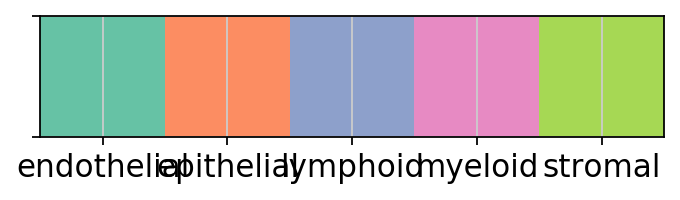

In [1]:
%load_ext autoreload
%autoreload 2

import itertools

# Third-party modules
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scanpy
import seaborn as sns
import matplotlib_venn
from tqdm import tqdm




# Olga's modules
import binarized
import enrich
import xspecies

outdir_gdrive = '/home/olga/googledrive/TabulaMicrocebus/data/cross-species'
outdir_local = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species'
outdirs = outdir_local, outdir_gdrive
# !ls -lha $outdir_local

In [2]:
1+1

2

# Load data

In [3]:
%%time
h5ad = f'{outdir_local}/concatenated__human-lung--lemur-lung--mouse-lung__10x__one2one_orthologs__unified_compartments__bbknn.h5ad'
!ls -lha $h5ad
adata = scanpy.read_h5ad(h5ad)
adata

-rw-rw-r-- 1 olga czb 731M May 18 21:46 /home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated__human-lung--lemur-lung--mouse-lung__10x__one2one_orthologs__unified_compartments__bbknn.h5ad
CPU times: user 530 ms, sys: 680 ms, total: 1.21 s
Wall time: 6.89 s


AnnData object with n_obs × n_vars = 52815 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', 'gene_ids

In [4]:
adata.obs.groupby(['compartment_group', 'species']).size()

compartment_group        species    
endothelial              Human           4196
                         Mouse           2072
                         Mouse lemur      937
epithelial               Human           6982
                         Mouse            162
                         Mouse lemur     2138
hematopoietic            Mouse lemur       46
lymphoid                 Human            804
                         Mouse           1298
                         Mouse lemur      901
megakaryocyte-erythroid  Human              9
myeloid                  Human          15013
                         Mouse           5893
                         Mouse lemur     7366
nan                      Mouse lemur      886
neural                   Human             10
                         Mouse              4
stromal                  Human           1866
                         Mouse           1774
                         Mouse lemur      458
dtype: int64

## Add compartment_narrow

In [5]:
adata.obs['compartment_narrow'] = adata.obs['compartment_group'].astype(str) + ': ' + adata.obs['narrow_group'].astype(str)
adata.obs['compartment_narrow_species'] = adata.obs['compartment_narrow'].astype(str) + ' (' + adata.obs['species_batch'].astype(str) + ')'
adata.obs['compartment_narrow'].value_counts()

myeloid: Macrophage                       18720
myeloid: Monocyte                          5892
epithelial: Alveolar Epithelial Type 2     4266
endothelial: Capillary                     2130
stromal: Alveolar Fibroblast               1713
                                          ...  
lymphoid: Innate Lymphoid                     9
stromal: Undistinguished Stromal              8
stromal: CTGF+ Fibroblast                     7
epithelial: Tuft                              5
endothelial: CX3CL1+ Capillary                4
Name: compartment_narrow, Length: 64, dtype: int64

In [6]:
adata.obs.species.unique()

[Human, Mouse lemur, Mouse]
Categories (3, object): [Human, Mouse lemur, Mouse]

In [7]:
adata.obs.species_batch.unique()

[human, lemur, mouse]
Categories (3, object): [human, lemur, mouse]

# Within-narrow group, run stability analyses

## Filter for minimum number of cells per cell type

In [8]:
groupby = 'compartment_narrow'
species = 'species_batch'

min_cells = 20
n_species = 3
df = adata.obs.groupby([groupby, species]).filter(lambda x: len(x) >= min_cells)
df = df.groupby(groupby)[species].filter(lambda x: x.nunique() == n_species)
print(df.shape)
df.head()

adata_min_cells = adata[df.index]
adata_min_cells

scanpy==1.4.6.dev9+ge632939 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1
compartment_narrow                      species    
endothelial: Capillary                  Mouse           1244
                                        Mouse lemur       44
                                        Human            842
endothelial: Capillary Aerocyte         Mouse            476
                                        Mouse lemur      111
                                        Human           1047
endothelial: Lymphatic                  Mouse             32
                                        Mouse lemur       68
                                        Human            286
epithelial: Alveolar Epithelial Type 2  Mouse            107
                                        Mouse lemur      732
                                        Human           3427
lymphoid: CD4+ T                    

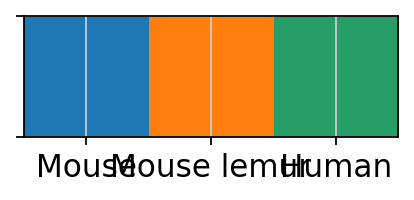

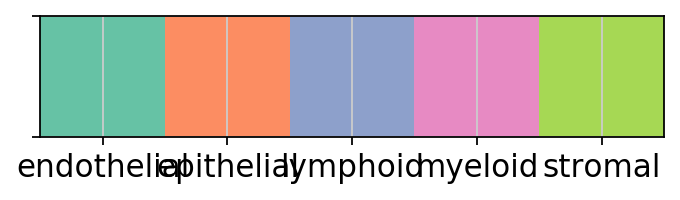

In [12]:
cross_species = xspecies.CrossSpeciesComparison(adata_min_cells, groupby)
cross_species._make_species_adatas(do_pca_umap=False)

In [14]:
# %%time

# stability_min_cells = binarized.BinarizedStabilityAnalyses(adata_min_cells, groupby, species, debug=True)
# stability_min_cells.do_stability_analysis(thresholds=np.arange(0, 0.55, step=0.05))


# 'HHIP' in stability_min_cells.stable_gene_names

# Get ligand-receptor pairs

In [15]:
receptor_ligand_pairs = pd.read_csv('https://raw.githubusercontent.com/krasnowlab/HLCA/master/Analysis/dbs/PairsLigRec.txt', 
                                    sep='\t', index_col=0)
print(receptor_ligand_pairs.shape)
receptor_ligand_pairs.head() 

## Filter by ligands and receptors actually present in the data

ligand_col = 'Ligand.ApprovedSymbol'
receptor_col = 'Receptor.ApprovedSymbol'

ligand_present = receptor_ligand_pairs[ligand_col].isin(adata.var.index)
receptor_present = receptor_ligand_pairs[receptor_col].isin(adata.var.index)

receptor_ligand_pairs_present = receptor_ligand_pairs.loc[ligand_present & receptor_present]
print(receptor_ligand_pairs_present.shape)
receptor_ligand_pairs_present.head()

## Ligand-centric analyes

In [17]:
cross_species.species_to_color_map = xspecies.SPECIES_TO_COLOR_MAP


for name, df in receptor_ligand_pairs_present.groupby(ligand_col):
    print(f'--- {name} ---')
    gene_subset = sorted(df[receptor_col].tolist())
    print(f'number of overlapping genes: {len(gene_subset)}')
    if not gene_subset:
        continue
    gene_subset = [name] + gene_subset
    
    save_dir = f'{outdir_gdrive}/ligand-receptor/ligand-centric/{name}/'
    ! mkdir -p $save_dir
    scanpy.settings.figdir = save_dir
    
    cross_species.dotplot_multispecies(gene_subset, save_prefix=name)

## Receptor-centric analyses

In [20]:

for name, df in receptor_ligand_pairs_present.groupby(receptor_col):
    print(f'--- {name} ---')
    gene_subset = sorted(df[ligand_col].tolist())
    print(f'number of overlapping genes: {len(gene_subset)}')
    if not gene_subset:
        continue
    gene_subset =  gene_subset + [name]
    
    save_dir = f'{outdir_gdrive}/ligand-receptor/receptor-centric/{name}/'
    ! mkdir -p $save_dir
    scanpy.settings.figdir = save_dir
    
    cross_species.dotplot_multispecies(gene_subset, save_prefix=save_prefix)

--- ABCA1 ---
number of overlapping genes: 5


NameError: name 'save_prefix' is not defined